In [60]:

import pandas as pd
import numpy as np
import joblib  
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

Data Exploration

In [61]:
# Load datasets
games = pd.read_csv("./Data/games.csv")
ranking = pd.read_csv("./Data/ranking.csv")

# Display first few rows
print("Games Dataset:\n", games.head())
print("\nRanking Dataset:\n", ranking.head())

# Display the shape of the datasets
print("\nGames Dataset Shape:", games.shape)
print("Ranking Dataset Shape:", ranking.shape)


Games Dataset:
   GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2022-12-22  22200477            Final    1610612740       1610612759   
1    2022-12-22  22200478            Final    1610612762       1610612764   
2    2022-12-21  22200466            Final    1610612739       1610612749   
3    2022-12-21  22200467            Final    1610612755       1610612765   
4    2022-12-21  22200468            Final    1610612737       1610612741   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
0    2022    1610612740     126.0        0.484        0.926  ...      25.0   
1    2022    1610612762     120.0        0.488        0.952  ...      16.0   
2    2022    1610612739     114.0        0.482        0.786  ...      22.0   
3    2022    1610612755     113.0        0.441        0.909  ...      27.0   
4    2022    1610612737     108.0        0.429        1.000  ...      22.0   

   REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT

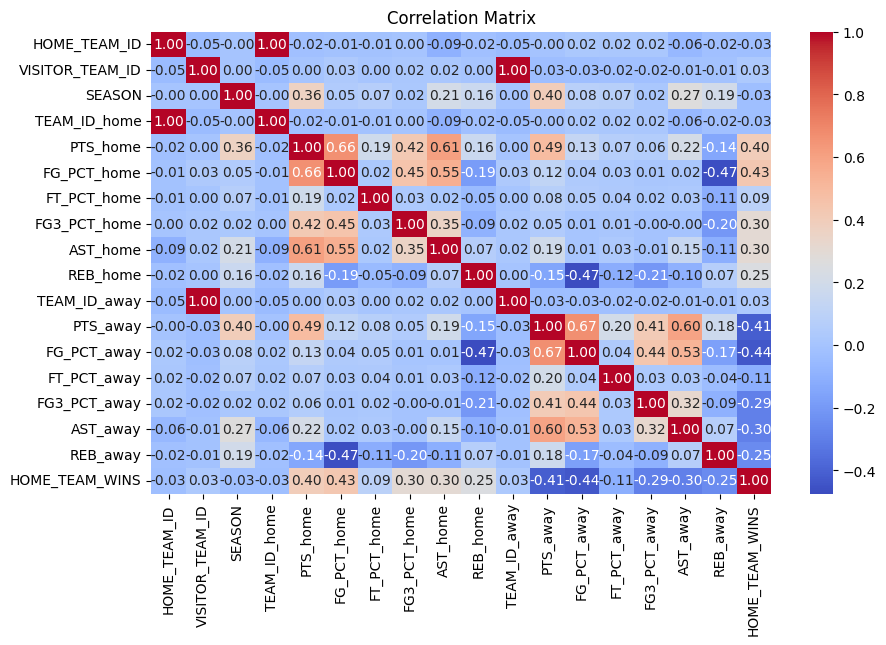

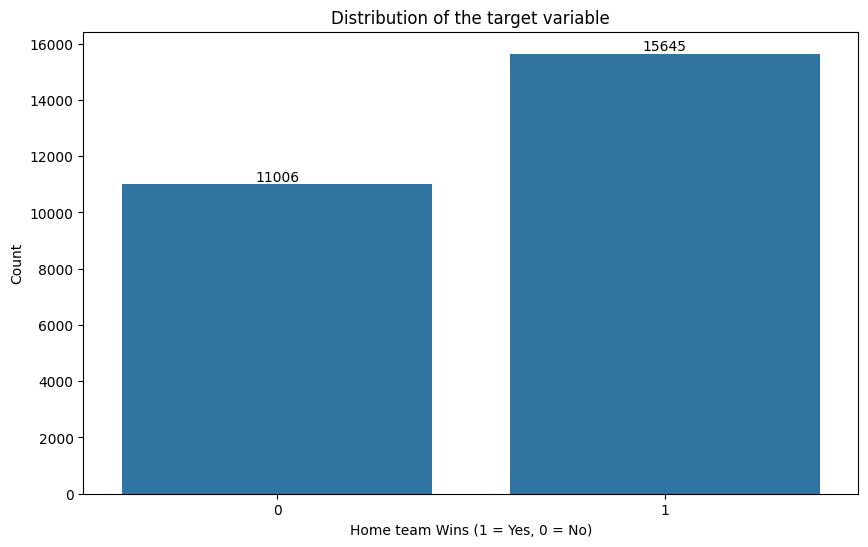

In [62]:
# Correlation heatmap for numerical features
ndata = games[games.columns[3:]]
# print(ndata.head())

plt.figure(figsize=(10, 6))
correlation_matrix = ndata.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


# plot the distribution of the target variable
plt.figure(figsize=(10, 6))
ax = sns.countplot(data = games,x="HOME_TEAM_WINS")
plt.title("Distribution of the target variable")
plt.xlabel("Home team Wins (1 = Yes, 0 = No)")
plt.ylabel("Count")


# Add count labels on top of each bar
for i in ax.containers:
    ax.bar_label(i)

plt.show()



In [63]:
# Merge datasets

# Select only the necessary columns
games = games[['GAME_ID', 'TEAM_ID_home', 'TEAM_ID_away', 'PTS_home', 'PTS_away','FG_PCT_home','FG_PCT_away', 'GAME_DATE_EST','HOME_TEAM_WINS']]
ranking = ranking[['TEAM_ID', 'STANDINGSDATE', 'G', 'W', 'L', 'W_PCT']]

# Convert date columns to datetime format
games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE_EST'])
ranking['STANDINGSDATE'] = pd.to_datetime(ranking['STANDINGSDATE'])

# merge games and ranking
games = pd.merge(games, ranking, left_on=['TEAM_ID_home', 'GAME_DATE'], right_on=['TEAM_ID', 'STANDINGSDATE'], how='left')
games = games.rename(columns={'G': 'G_home', 'W': 'W_home', 'L': 'L_home', 'W_PCT': 'W_PCT_home'})
games = games.drop(columns=['TEAM_ID'])

games = pd.merge(games, ranking, left_on=['TEAM_ID_away', 'GAME_DATE'], right_on=['TEAM_ID', 'STANDINGSDATE'], how='left')
games = games.rename(columns={'G': 'G_away', 'W': 'W_away', 'L': 'L_away', 'W_PCT': 'W_PCT_away'})
games = games.drop(columns=['TEAM_ID'])

# Drop redundant columns
games = games.drop(columns=[ 'STANDINGSDATE_x', 'STANDINGSDATE_y', 'GAME_DATE_EST'])

# Display the merged dataset
print("\nMerged Dataset:\n", games.head())



Merged Dataset:
     GAME_ID  TEAM_ID_home  TEAM_ID_away  PTS_home  PTS_away  FG_PCT_home  \
0  22200477    1610612740    1610612759     126.0     117.0        0.484   
1  22200478    1610612762    1610612764     120.0     112.0        0.488   
2  22200466    1610612739    1610612749     114.0     106.0        0.482   
3  22200467    1610612755    1610612765     113.0      93.0        0.441   
4  22200468    1610612737    1610612741     108.0     110.0        0.429   

   FG_PCT_away  HOME_TEAM_WINS  GAME_DATE  G_home  W_home  L_home  W_PCT_home  \
0        0.478               1 2022-12-22      31      19      12       0.613   
1        0.561               1 2022-12-22      35      19      16       0.543   
2        0.470               1 2022-12-21      33      22      11       0.667   
3        0.392               1 2022-12-21      30      18      12       0.600   
4        0.500               0 2022-12-21      32      16      16       0.500   

   G_away  W_away  L_away  W_PCT_away 

In [64]:
games

,GAME_ID,TEAM_ID_home,TEAM_ID_away,PTS_home,PTS_away,FG_PCT_home,FG_PCT_away,HOME_TEAM_WINS,GAME_DATE,G_home,W_home,L_home,W_PCT_home,G_away,W_away,L_away,W_PCT_away
0,22200477,1610612740,1610612759,126.0,117.0,0.484,0.478,1,2022-12-22,31,19,12,0.613,31,10,21,0.323
1,22200478,1610612762,1610612764,120.0,112.0,0.488,0.561,1,2022-12-22,35,19,16,0.543,33,12,21,0.364
2,22200466,1610612739,1610612749,114.0,106.0,0.482,0.470,1,2022-12-21,33,22,11,0.667,31,22,9,0.710
3,22200467,1610612755,1610612765,113.0,93.0,0.441,0.392,1,2022-12-21,30,18,12,0.600,34,8,26,0.235
4,22200468,1610612737,1610612741,108.0,110.0,0.429,0.500,0,2022-12-21,32,16,16,0.500,31,13,18,0.419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26666,11400007,1610612737,1610612740,93.0,87.0,0.419,0.366,1,2014-10-06,1,1,0,1.000,2,1,1,0.500
26667,11400004,1610612741,1610612764,81.0,85.0,0.338,0.411,0,2014-10-06,1,0,1,0.000,1,1,0,1.000
26668,11400005,1610612747,1610612743,98.0,95.0,0.448,0.387,1,2014-10-06,1,1,0,1.000,1,0,1,0.000
26669,11400002,1610612761,1610612758,99.0,94.0,0.440,0.469,1,2014-10-05,1,1,0,1.000,1,0,1,0.000


Feature Engineering

In [65]:
# Create win rate difference
games['win_rate_diff'] = games['W_PCT_home'] - games['W_PCT_away']

# Create field goal percentage difference
games['fg_pct_diff'] = games['FG_PCT_home'] - games['FG_PCT_away']

# Rolling averages for points in last 5 games
games = games.sort_values(by=['GAME_DATE'])  # Sort by date
games['home_avg_pts'] = games.groupby('TEAM_ID_home')['PTS_home'].transform(lambda x: x.rolling(5, min_periods=1).mean())
games['away_avg_pts'] = games.groupby('TEAM_ID_away')['PTS_away'].transform(lambda x: x.rolling(5, min_periods=1).mean())

# Select final feature set
features = ['W_PCT_home', 'W_PCT_away', 'win_rate_diff', 
            'FG_PCT_home', 'FG_PCT_away', 'fg_pct_diff', 
            'home_avg_pts', 'away_avg_pts', 'HOME_TEAM_WINS']

df = games[features]

# Handle missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())
df.dropna(inplace=True)




Missing Values per Column:
W_PCT_home         0
W_PCT_away         0
win_rate_diff      0
FG_PCT_home       99
FG_PCT_away       99
fg_pct_diff       99
home_avg_pts      56
away_avg_pts      64
HOME_TEAM_WINS     0
dtype: int64


C:\Users\win_10\AppData\Local\Temp\ipykernel_1516\1172880936.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


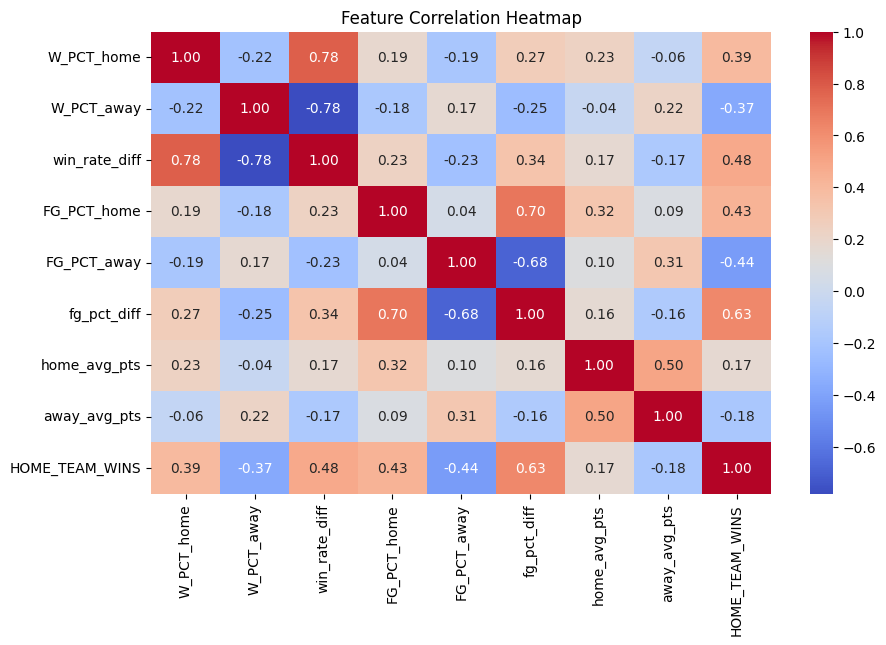

In [66]:
# Display correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Model Training

In [67]:
# Define features and target variable
X = df.drop(columns=['HOME_TEAM_WINS'])  # Features
y = df['HOME_TEAM_WINS']  # Target

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize results storage
model_results = {}

# List to store ROC curves
roc_curves = {}

plt.figure(figsize=(10, 6))


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

Baseline Model: Dummy Classifier


Dummy Classifier Results:
Accuracy:  0.6045155221072437
Precision:  0.6045155221072437
Recall:  1.0
F1 Score:  0.7535178236397748
ROC AUC:  0.5


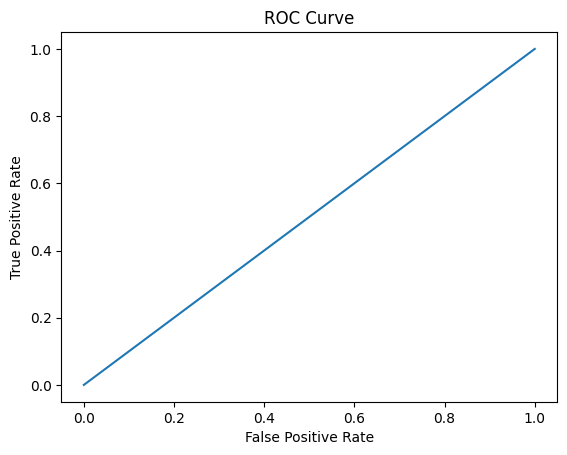

In [68]:

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)
y_probs_dummy = dummy_clf.predict_proba(X_test)[:, 1]

model_results["Dummy Classifier"] = {
    "Accuracy": accuracy_score(y_test, y_pred_dummy),
    "Precision": precision_score(y_test, y_pred_dummy),
    "Recall": recall_score(y_test, y_pred_dummy),
    "F1 Score": f1_score(y_test, y_pred_dummy),
    "ROC AUC": roc_auc_score(y_test, y_probs_dummy)
}

print("\nDummy Classifier Results:")
print("Accuracy: ", model_results["Dummy Classifier"]["Accuracy"])
print("Precision: ", model_results["Dummy Classifier"]["Precision"])
print("Recall: ", model_results["Dummy Classifier"]["Recall"])
print("F1 Score: ", model_results["Dummy Classifier"]["F1 Score"])
print("ROC AUC: ", model_results["Dummy Classifier"]["ROC AUC"])


fpr, tpr, _ = roc_curve(y_test, y_probs_dummy)
roc_curves["Dummy Classifier"] = (fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr, tpr, label=f"Dummy Classifier (AUC = {model_results['Dummy Classifier']['ROC AUC']:.2f})")

Random Forest with Grid search tunning


Random Forest Results:
Accuracy:  0.8436500470366887
Precision:  0.8707970112079702
Recall:  0.870525988173047
F1 Score:  0.8706614785992218
ROC AUC:  0.9262986090937062


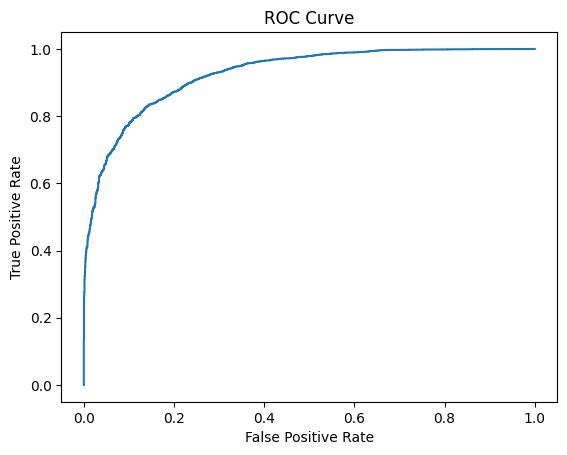

In [73]:
rf_model = RandomForestClassifier()
rf_params = {'n_estimators': [50, 100,200], 'max_depth': [10,20, None]}

rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

y_pred_rf = rf_best.predict(X_test)
y_probs_rf = rf_best.predict_proba(X_test)[:, 1]

model_results["Random Forest"] = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1 Score": f1_score(y_test, y_pred_rf),
    "ROC AUC": roc_auc_score(y_test, y_probs_rf)
}


print("\nRandom Forest Results:")
print("Accuracy: ", model_results["Random Forest"]["Accuracy"])
print("Precision: ", model_results["Random Forest"]["Precision"])
print("Recall: ", model_results["Random Forest"]["Recall"])
print("F1 Score: ", model_results["Random Forest"]["F1 Score"])
print("ROC AUC: ", model_results["Random Forest"]["ROC AUC"])

fpr, tpr, _ = roc_curve(y_test, y_probs_rf)
roc_curves["Random Forest"] = (fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {model_results['Random Forest']['ROC AUC']:.2f})")


K-Nearest Neighbors (KNN)


KNN Results:
Accuracy:  0.8297271872060207
Precision:  0.8608505315822389
Recall:  0.8568316215375039
F1 Score:  0.8588363749805022
ROC AUC:  0.8999073252305468


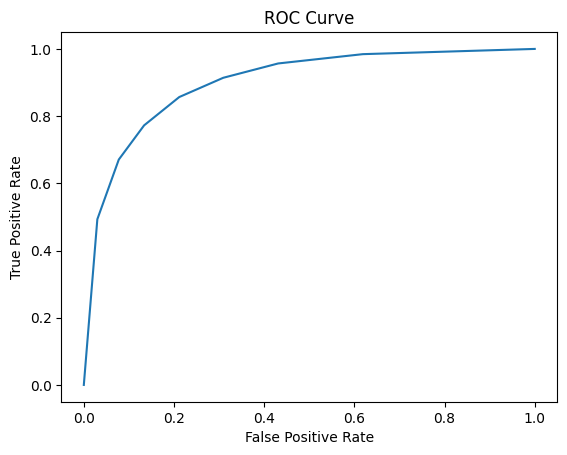

In [74]:
knn_model = KNeighborsClassifier()
knn_params = {'n_neighbors': [3, 5, 7]}

knn_grid = GridSearchCV(knn_model, knn_params, cv=5, scoring='roc_auc', n_jobs=-1)
knn_grid.fit(X_train, y_train)
knn_best = knn_grid.best_estimator_

y_pred_knn = knn_best.predict(X_test)
y_probs_knn = knn_best.predict_proba(X_test)[:, 1]

model_results["KNN"] = {
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "Precision": precision_score(y_test, y_pred_knn),
    "Recall": recall_score(y_test, y_pred_knn),
    "F1 Score": f1_score(y_test, y_pred_knn),
    "ROC AUC": roc_auc_score(y_test, y_probs_knn)
}

print("\nKNN Results:")
print("Accuracy: ", model_results["KNN"]["Accuracy"])
print("Precision: ", model_results["KNN"]["Precision"])
print("Recall: ", model_results["KNN"]["Recall"])
print("F1 Score: ", model_results["KNN"]["F1 Score"])
print("ROC AUC: ", model_results["KNN"]["ROC AUC"])


fpr, tpr, _ = roc_curve(y_test, y_probs_knn)
roc_curves["KNN"] = (fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr, tpr, label=f"KNN (AUC = {model_results['KNN']['ROC AUC']:.2f})")
